In [1]:
import sympy as sym
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import control
# from ipywidgets import interact

s = sym.symbols('s', complex=True)


# Diseño de controladores mediante Lugar Geométrico de las Raíces



Se busca encontrar compensadores a partir de análisis del **Lugar Geométrico de las Raíces**.

Los compensadores se diseñan para que los procesos desarrollen tareas específicas cumpliendo con especificaciones del comportamiento en la respuesta transitoria (tiempo de estabilización, máxima sobreelongación, etc) y estacionaria (error de estado estable).



## Método

Se añaden polos y ceros (del compensador) a la función de transferencia del sistema en lazo directo $G(s)$, de manera que el **Lugar Geométrico de las Raíces** pase por los polos deseados en lazo cerrado. Una vez se garantiza que el **Lugar Geométrico de las Raíces** pasa por los polos deseados, se encuentra la ganancia del compensador que permite que el sistema en lazo cerrado se comporte según los polos deseados.

Tenga en cuenta que la función de transferencia de lazo cerrado, en un sistema controlado con realimentación unitaria, es:

$$G_{LC} = \frac{G(s)}{1+G(s)}$$

Los valores de $s$ que conforman el Lugar Geométrico de las Raíces cumplen que:

$$1+G(s) = 0$$

Que es equivalente a:

$$G(s) = -1$$

De donde se genera la condición de fase:

$$\angle G(s) = \pm 180 ^o$$

Y la condición de magnitud:

$$ | G(s) | = 1$$

### Compensador en adelanto

Los pasos para diseñar un compensador mediante el Lugar Geométrico de las Raíces son:

1. Determine la localización deseada para los polos dominantes en lazo cerrado.

2. A partir del Lugar Geométrico de las Raíces, determine si un ajuste de ganancia puede brindar el comportamiento deseado. Si no, encuentre el ángulo que debe aportar el compensador para que el Lugar Geométrico de las Raíces pase por los polos deseados.

3. Suponga la forma de un compensador 

$$ G_c(s) = k_c\frac{s+\frac{1}{T}}{s+\frac{1}{\alpha T}}$$

donde los parámetros $k_c$, $\alpha$ y $T$ se determinan a partir de los requisitos del sistema.

4. Encuentre $\alpha$ y $T$ para garanttizar que el Lugar Geométrico de las Raíces pase por los polos deseados con la condición de fase.

5. Encuentre $k_c$ a partir de la condición de magnitud.

**Ejemplo**

Suponga un proceso cuyo modelo es:

$$G_p(s) = \frac{4}{s\left ( s+2 \right )}$$

In [2]:
# Se define la función de transferencia del proceso
Gp = control.tf(4, [1,2,0])
Gp

TransferFunction(array([4]), array([1, 2, 0]))

Si se realimenta el sistema con un compensador $G_c(s)=1$

In [3]:
G_LC1 = control.feedback(Gp,1)

Los polos y ceros del sistema en lazo cerrado serían:

In [4]:
# Polos de lazo con Gc(s) = 1
pLC1 = G_LC1.pole()
pLC1

array([-1.+1.73205081j, -1.-1.73205081j])

In [5]:
# Ceros de lazo con Gc(s) = 1
cLC1 = G_LC1.zero()
cLC1

array([], dtype=float64)

Suponga que requiere disminuir el tiempo de estabilización a la mitad del que obtendría al realimenta con $G_c(s)=1$ manteniendo el amortiguamiento.

In [6]:
# Polos de lazo cerrado deseados
pLC_deseado = 2*pLC1
pLC_deseado

array([-2.+3.46410162j, -2.-3.46410162j])

Se verifica si los polos deseados hacen parte del Lugar Geométrico de las Raíces.

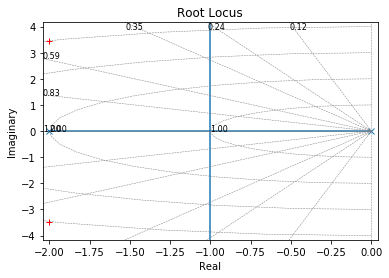

In [7]:
_,_ = control.root_locus(Gp,plot = True);
plt.plot(pLC_deseado.real, pLC_deseado.imag, 'r+')

Como los polos deseados no hacen parte del Lugar Geométrico de las Raíces, se define una forma de compensador.

$$ G_c(s) = k_c\frac{s+\frac{1}{T}}{s+\frac{1}{\alpha T}}$$

y la función de transferencia de lazo directo:

$$ G(s) = G_c(s)G_p(s)$$


In [8]:
G_p_sym = 4/(s**2+2*s)
G_p_sym

4/(s**2 + 2*s)

Al evaluar la función de transferencia del proceso en los polos deseados se obtiene:

In [9]:
G_p_sym_des = G_p_sym.subs(s,pLC_deseado[0]).simplify()
G_p_sym_des

-0.25 + 0.144337567297406*I

Este número complejo equivale a una magnitud

In [10]:
sym.Abs(G_p_sym_des)

0.288675134594813

y una fase

In [11]:
sym.arg(G_p_sym_des)

-0.523598775598299 + pi

La condición de fase indica que el compensador debe aportar un ángulo que lleve el ángulo completo a $\pm 180^o$, en este caso:


In [12]:
ang_comp = -(sym.arg(G_p_sym_des) - sym.pi)
ang_comp

0.523598775598299

por lo que se requiere un compensador.  Se propone usar 

$$ G_c(s) = k_c\frac{s+\frac{1}{T}}{s+\frac{1}{\alpha T}}$$


In [13]:
kc,T,alpha = sym.symbols('k_c,T,alpha', real=True,positive = True)


G_c_sym = kc*(s+1/T)/(s+1/(alpha*T))
G_c_sym

k_c*(s + 1/T)/(s + 1/(T*alpha))

El ángulo que aporta el compensador es:

In [14]:
sym.arg(G_c_sym.subs(s,pLC_deseado[0]).simplify())

arg((T*(-2.0 + 3.46410161513775*I) + 1)/(T*alpha*(-2.0 + 3.46410161513775*I) + 1))

Observe que tiene dos parámetros y una sola condición. En este caso se selecciona un parámetro de forma arbitraria para determinar el otro.

Una posible solución es ubicar el cero del compensador bajo el polo deseado.

$$-2+\frac{1}{T} = 0$$
$$T = \frac{1}{2}$$

y se soluciona la condición de fase

In [15]:
parametros = {T:1/2}

In [16]:
CondFase = sym.arg(G_c_sym.subs(s,pLC_deseado[0]).
                   subs(parametros))-ang_comp
sym.solve(CondFase,alpha)

[0.500000000000000]

In [17]:
parametros = {T:1/2, alpha:0.5}

In [18]:
G_c_sym.subs(parametros)

k_c*(s + 2.0)/(s + 4.0)

Así, el compensador es:

$$G_c(s) = k_c \frac{s+2}{s+4}$$

Y falta encontrar $k_c$

In [19]:
Gc = control.tf([1,2],[1,4])
Gc

TransferFunction(array([1, 2]), array([1, 4]))

In [20]:
G = Gc*Gp
G

TransferFunction(array([4., 8.]), array([1, 6, 8, 0]))

El Lugar Geométrico de las Raíces del proceso y el compensador es:

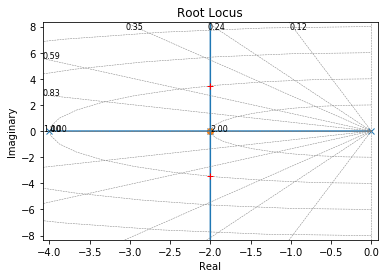

In [21]:
_,_ = control.root_locus(G,plot = True);
plt.plot(pLC_deseado.real, pLC_deseado.imag, 'r+')

Ahora debe hallarse $k_c$ con la condición de magnitud.

Ya se ha calculado que la magnitud del proceso evaluado en el polo deseado es:

In [22]:
sym.Abs(G_p_sym_des)

0.288675134594813

Por lo que el compensador debe aportar una magnitud de:

In [23]:
mag_comp = 1/sym.Abs(G_p_sym_des)

In [24]:
CondMag = sym.Abs(G_c_sym.subs(s,pLC_deseado[0]).
                   subs(parametros))/mag_comp - 1
sym.solve(CondMag,kc)

[4.00000000000000]

In [25]:
parametros = {T:1/2, alpha:0.5, kc: 4}

Y  el compensador es:

In [26]:
G_c_sym.subs(parametros)

4*(s + 2.0)/(s + 4.0)

In [27]:
Gc = 4*control.tf([1,2],[1,4])
Gc

TransferFunction(array([4., 8.]), array([1, 4]))

In [28]:
G = Gc*Gp
G

TransferFunction(array([16., 32.]), array([1, 6, 8, 0]))

Verifique el comportamiento en el dominio del tiempo

**Respuesta al escalón del proceso sin compensador**


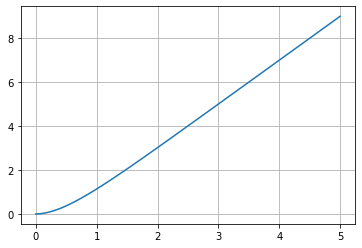

In [29]:
ts = np.linspace(0, 5, 1000)

_, yLA = control.step_response(Gp, ts)
plt.plot(ts,yLA)
plt.grid()


**Respuesta al escalón del proceso realimentado**


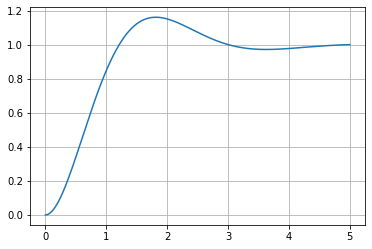

In [30]:

_, yLC1 = control.step_response(control.feedback(Gp,1),ts)
plt.plot(ts,yLC1)
plt.grid()


**Respuesta al escalón del proceso con compensador**


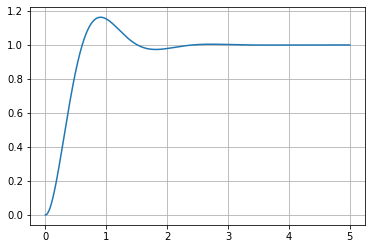

In [31]:

_, yLC = control.step_response(control.feedback(Gc*Gp,1),ts)
plt.plot(ts,yLC)
plt.grid()


Puede compararse la respuesta del sistema solo realimentado con la respuesta del sistema compensado

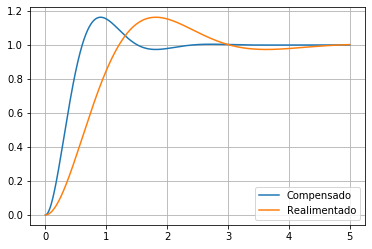

In [32]:
plt.plot(ts,yLC,ts,yLC1)
plt.legend(('Compensado','Realimentado'))
plt.grid()


Observe que el sistema controlado tiene un **error de estado estale** nulo para una entrada escalón. ¿Qué ocurre si la referencia es una rampa?

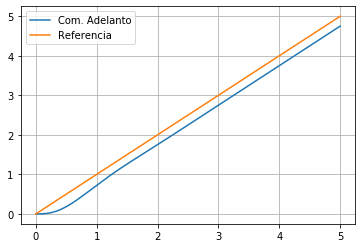

In [33]:
_, yLCr = control.step_response(control.feedback(Gc*Gp,1)*
                                control.tf(1,[1,0]),ts)
plt.plot(ts,yLCr)
plt.plot([ts[0],ts[-1]], [0,ts[-1]])
plt.legend(('Com. Adelanto','Referencia'))
plt.grid()

¿Cómo disminuir el error en estado estable sin afectar drásticamente la respuesta transitoria?

-----------------------
**Ejercicio**

Considere el proceso modelado por

$$G_p(s) =  \frac{5}{s(s+4)(s+10)}$$

Encuentre un compensador para que los polos dominantes en lazo cerrado estén en $-3 \pm j3$